# Imports

In [341]:
import sys, os

from math import log10
from numpy import array, pi

import pandas as pd
import numpy as np
from numpy import concatenate
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.base import clone
# algorithms:
from sklearn.tree import export_graphviz, DecisionTreeClassifier#, plot_tree, export_text # Available in later versions
#import graphviz

# Setup plotting

In [342]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

SE_size = 47.07

# Parameters

# Get data

In [343]:
df1 = pd.read_csv('tritium_ML_data.csv')
df2 = pd.read_csv('bg_sr1_vetoes.csv')
df3 = pd.read_csv('bg_sr1_vetoes_gassplit.csv')

df = pd.concat([df1,df3], ignore_index=True)
df = df.drop('Unnamed: 0', axis = 1)
df.head()


,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


# Re-weight data

In [344]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

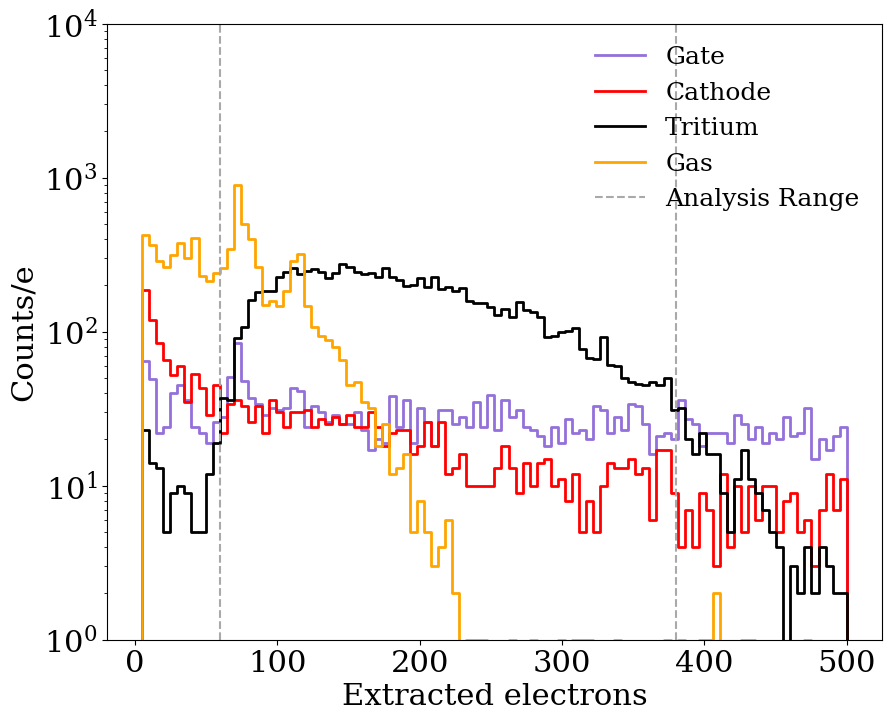

In [345]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
gas_hist.fill(df.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cathode"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [346]:
# implementing thresholds
thresh_cut = (60 < df.ext_elec) & (df.ext_elec < 380)
df_cut_gas = df[thresh_cut].reset_index().drop('index', axis = 1)

In [40]:
# handscanning the weird cathode data bumps 
S2_gate_cut = (100 < df.ext_elec) & (df.ext_elec < 140) 
for ii in range(1,11):
    print('%s\t%s'%(df.runID[S2_gate_cut&gate_cut].to_numpy()[ii], df.eventID[S2_gate_cut&gate_cut].to_numpy()[ii]))
    


6946	57616
7066	120832
7023	98841
7016	124942
6945	133297
6945	134428
6944	93160
7024	106409
6975	17189
6965	132098


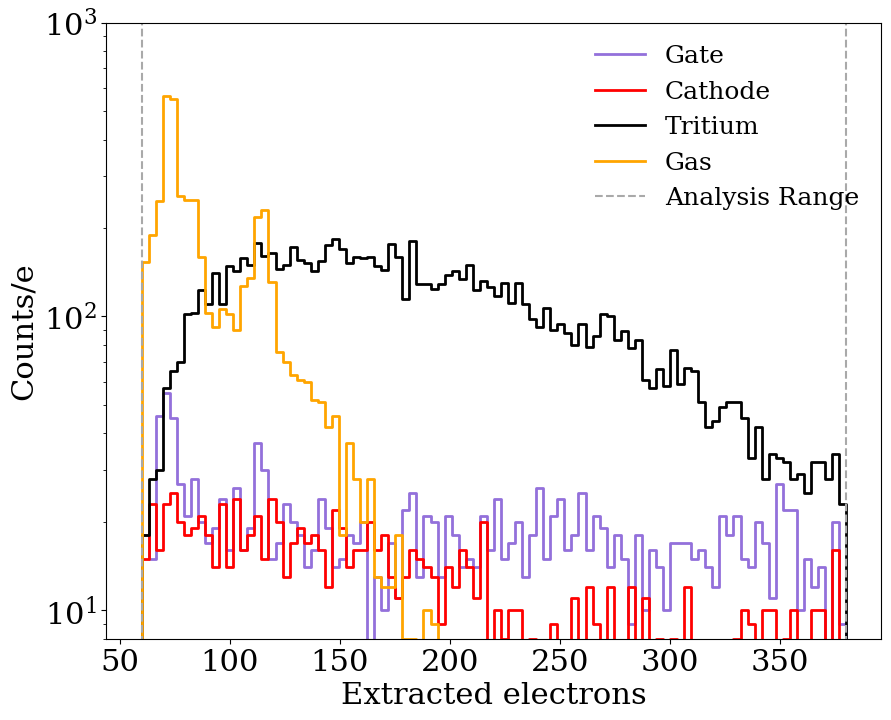

In [347]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_cut_gas.type == "gate"
gate_hist2.fill(df_cut_gas.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_cut_gas.type == "cathode"
cath_hist2.fill(df_cut_gas.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_cut_gas.type == "tritium"
trit_hist2.fill(df_cut_gas.ext_elec[trit_cut2])

gas_hist2 = Hist(electron_axis2)
gas_cut2 = df_cut_gas.type == "gas"
gas_hist2.fill(df_cut_gas.ext_elec[gas_cut2])


fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist2.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,1000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [348]:
#weighting data w/o gas events 
weight_list = []

for ii in range(df_cut_gas.shape[0]):
    if df_cut_gas.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_cut_gas.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_cut_gas.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_cut_gas['weights_no_gas'] = weight_list

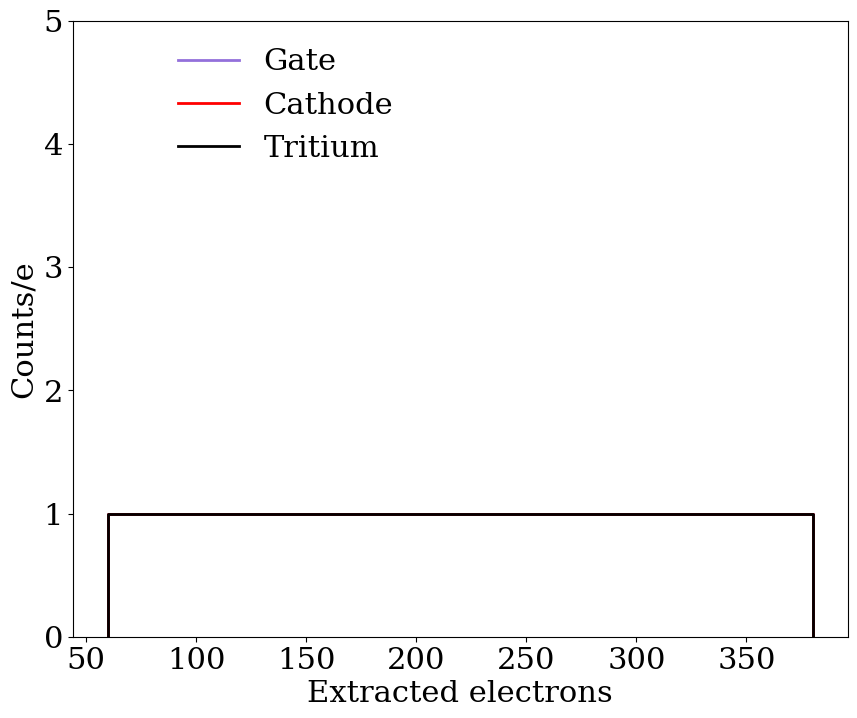

In [349]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_cut_gas.ext_elec[gate_cut2],weight = df_cut_gas.weights_no_gas[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_cut_gas.ext_elec[cath_cut2],weight = df_cut_gas.weights_no_gas[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_cut_gas.ext_elec[trit_cut2],weight = df_cut_gas.weights_no_gas[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

# Machine learning

### Prepare data for machine learning

In [350]:
df_cut_gas.loc[df_cut_gas["type"] == "tritium", "label"] = 1
df_cut_gas.loc[df_cut_gas["type"] == "gate", "label"] = 0
df_cut = df_cut_gas[df_cut_gas["type"] != 'gas'] #removing gas events


In [421]:
df_gate = df_cut[df_cut["type"] != 'gate']
features = ['max_pulse_height',
       'dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90',
       'ext_elec']

X = df_cut[features]
Y = df_cut['label']
T = df_cut['type']
W = df_cut['weights_no_gas'] # - should this be the weight calculated above? 
A = df_cut['area']
R = df_cut['r']
X_raw = df_cut['x']
Y_raw = df_cut['y']
eventID = df_cut['eventID']
runID = df_cut['runID']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
T_train, T_test, \
W_train, W_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test,  \
eventID_train, eventID_test, \
runID_train, runID_test = \
train_test_split(X, Y, A, T, W, R, X_raw, Y_raw, eventID, runID, random_state=0)

In [422]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
X_test = scaler.transform(X_test_unscaled.astype('float64'))
E_test = A_test/SE_size

### Adaptively boosted decision tree

In [423]:
DTC = DecisionTreeClassifier(max_depth=1,min_samples_split=2)
ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')
model = ABC.fit(X_train, Y_train.values.ravel()
                ,sample_weight=W_train.values.ravel().astype('float64'))

Y_score = model.decision_function(X_test)

model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 

C:\Users\lizzi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.884874248104353, 0.8839847185074619)

# Understanding machine learning

In [424]:
bin_labels = ['Total', r'60 < $n_e$ < 100', r'100 < $n_e$ < 140', r'140 < $n_e$ < 180', r'180 < $n_e$ < 220',
              r'220 < $n_e$ < 240', r'240 < $n_e$ < 280', r'280 < $n_e$ < 320', r'320 < $n_e$ < 380']
bin_colors = ["black", "purple", "darkblue", "cyan", "green", "gold", "orange", "red", "hotpink"  ]

In [435]:
test_error_list = []
start = 60
tritium_cut = T_test == 'tritium'
for i in range(8):
    test_error = [ ]
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    for test_predict in model.staged_predict(X_test[bin_cut & tritium_cut]):
        test_error.append(1.-accuracy_score(test_predict,Y_test[bin_cut & tritium_cut],sample_weight=W_test[bin_cut & tritium_cut].ravel().astype('float64')))
    test_error_list.append(test_error)

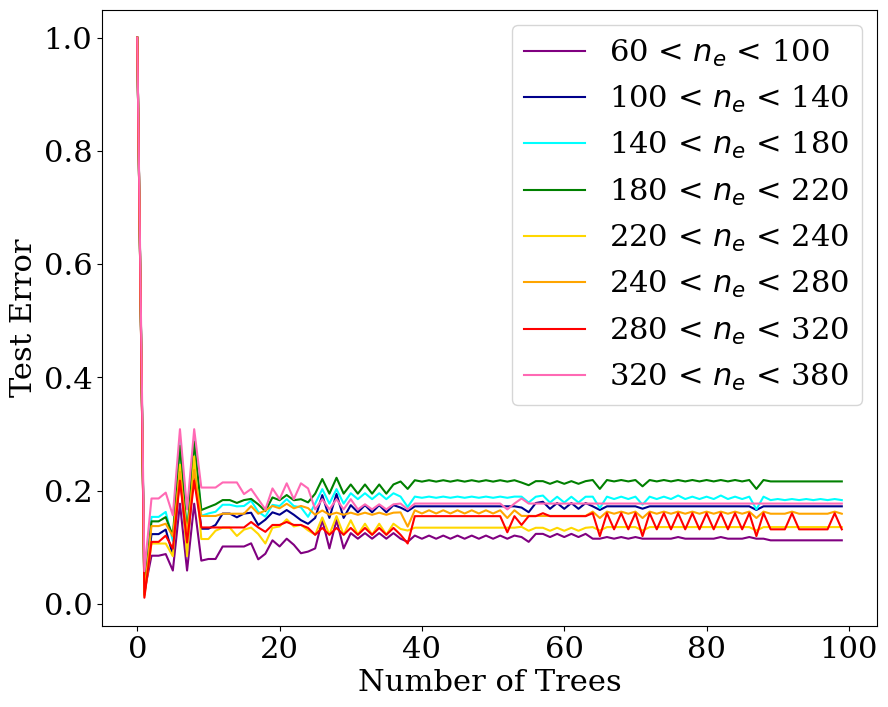

In [436]:
#test error - these are very weird 
for i in range(8):
    #ax.legend(fontsize = 12)
    plt.xlabel('Number of Trees')
    plt.ylabel('Test Error')
    plt.plot(test_error_list[i], color = bin_colors[i+1], label=bin_labels[i+1])
    plt.legend()
    #plt.show()



# Results

In [427]:
FPR_T, TPR_T, TH_T = roc_curve(Y_test,Y_score,sample_weight = W_test, pos_label = 1)

# Bins for ROC curves 

- Full range (60-380)
- For now will do evenly spaced bins i.e:
60-100
100-140
140-180
180-220
220-260
260-300
300-340
340-380


In [428]:
#bin1 = (60 < E_test) & (E_test < 100) 
#bin2 = (100 < E_test) & (E_test < 140) 
#bin3 = (140 < E_test) & (E_test < 180) 
#bin4 = (180 < E_test) & (E_test < 220) 
#bin5 = (220 < E_test) & (E_test < 260) 
#bin6 = (260 < E_test) & (E_test < 300) 
#bin7 = (300 < E_test) & (E_test < 340) 
#bin8 = (340 < E_test) & (E_test < 380) 
#bin_cuts = [[], bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8] - keeping these unless I want to do uneven binning


In [429]:
ROC_params_list = [[FPR_T, TPR_T, TH_T]]
Y_score = model.decision_function(X_test)
start = 60
for i in range(8): 
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    FPR, TPR, TH = roc_curve(Y_test[bin_cut],Y_score[bin_cut],sample_weight = W_test[bin_cut], pos_label = 1)
    ROC_params_list.append([FPR, TPR, TH])
   

In [430]:
# Finding max efficiency ratio 
def eff_calc(e_s, e_b):
        return np.divide(e_s, np.sqrt(e_b), out=np.zeros_like(e_s), where=e_b!=0)
maxes = []
ratios_list = []
for i in range(9):
    ratios = eff_calc(ROC_params_list[i][1], ROC_params_list[i][0])
    ratios_list.append(ratios)
    ind = np.where(ratios == np.max(ratios))
    maxes.append([ROC_params_list[i][1][ind], ROC_params_list[i][0][ind]])
    

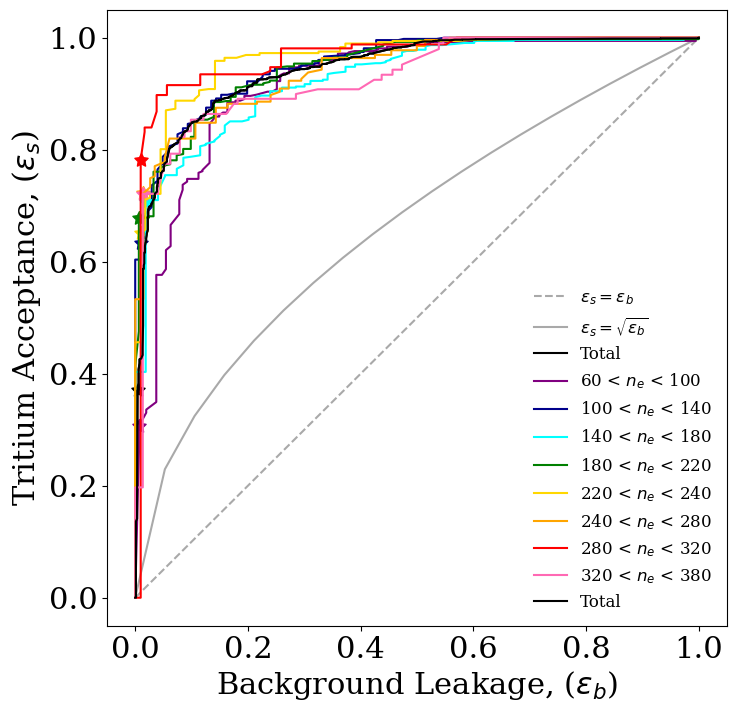

In [431]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(9):
    ax.plot(ROC_params_list[i][0], ROC_params_list[i][1], label = bin_labels[i], color = bin_colors[i])
    ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Background Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)


In [432]:
# splitting into gate and cathode
ROC_params_gate = []
ROC_params_cath = []
disc_score_cath = []
start = 60
for i in range(8): 
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    gate_cut_ =  T_test != 'cathode' 
    FPR, TPR, TH = roc_curve(Y_test[bin_cut&gate_cut_],Y_score[bin_cut&gate_cut_],sample_weight = W_test[bin_cut&gate_cut_], pos_label = 1)
    ROC_params_gate.append([FPR, TPR, TH])
    cath_cut_ =  T_test != 'gate' 
    FPR, TPR, TH = roc_curve(Y_test[bin_cut&cath_cut_],Y_score[bin_cut&cath_cut_],sample_weight = W_test[bin_cut&cath_cut_], pos_label = 1)
    ROC_params_cath.append([FPR, TPR, TH])
    disc_score_cath.append(Y_score[bin_cut&cath_cut_])


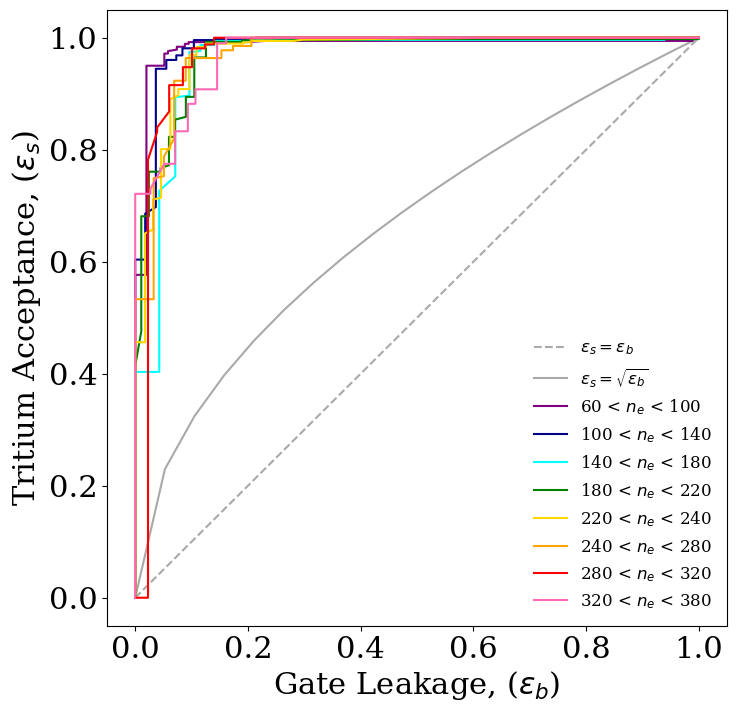

In [433]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_gate[i][0], ROC_params_gate[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

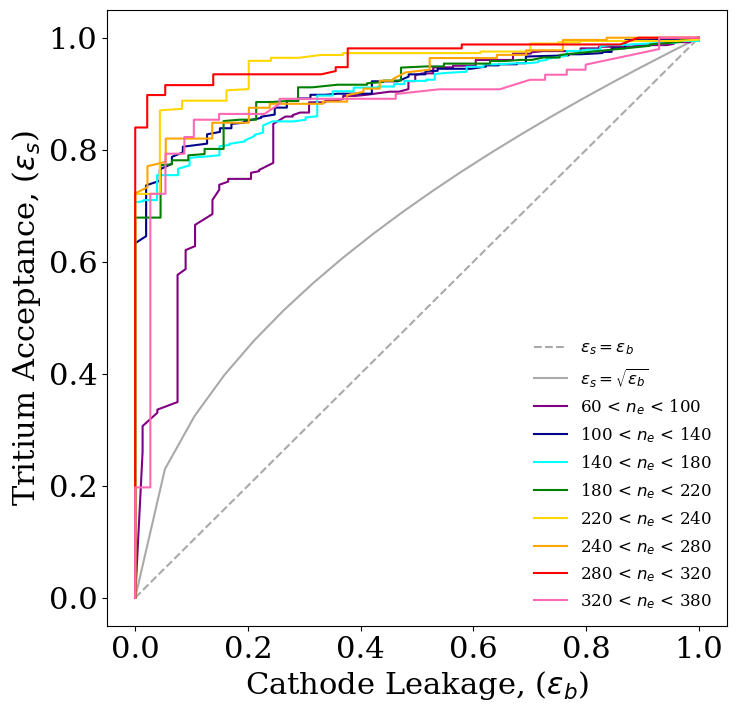

In [434]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_cath[i][0], ROC_params_cath[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Cathode Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

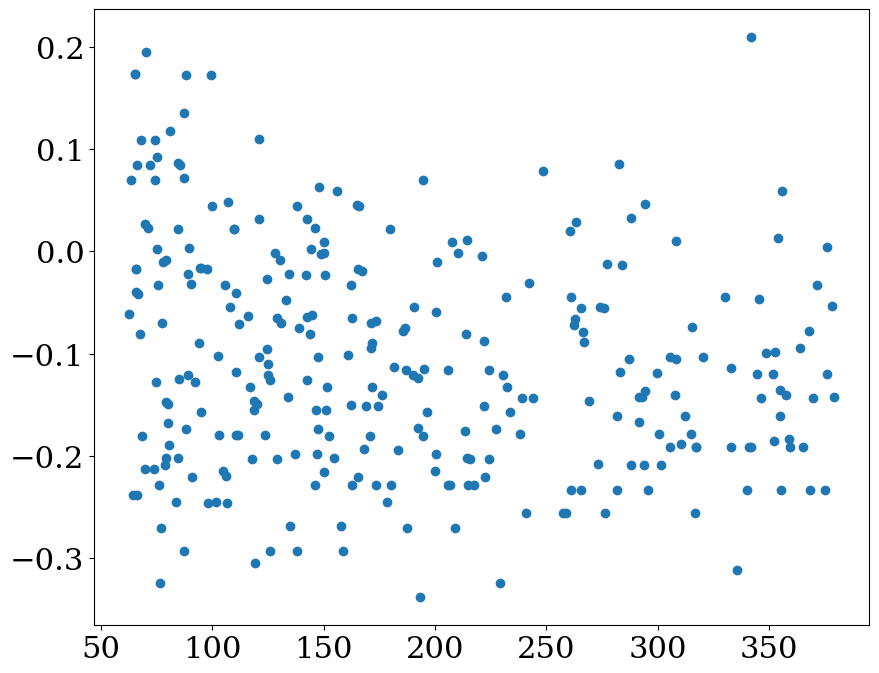

In [391]:
plt.scatter(E_test[T_test == 'cathode'], Y_score[T_test == 'cathode'])

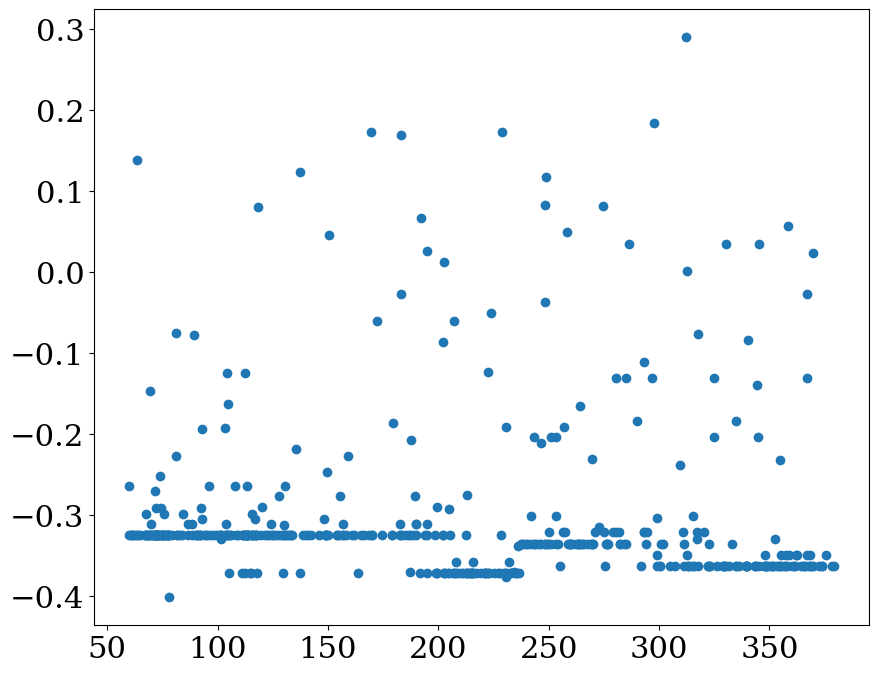

In [392]:
plt.scatter(E_test[T_test == 'gate'], Y_score[T_test == 'gate'])

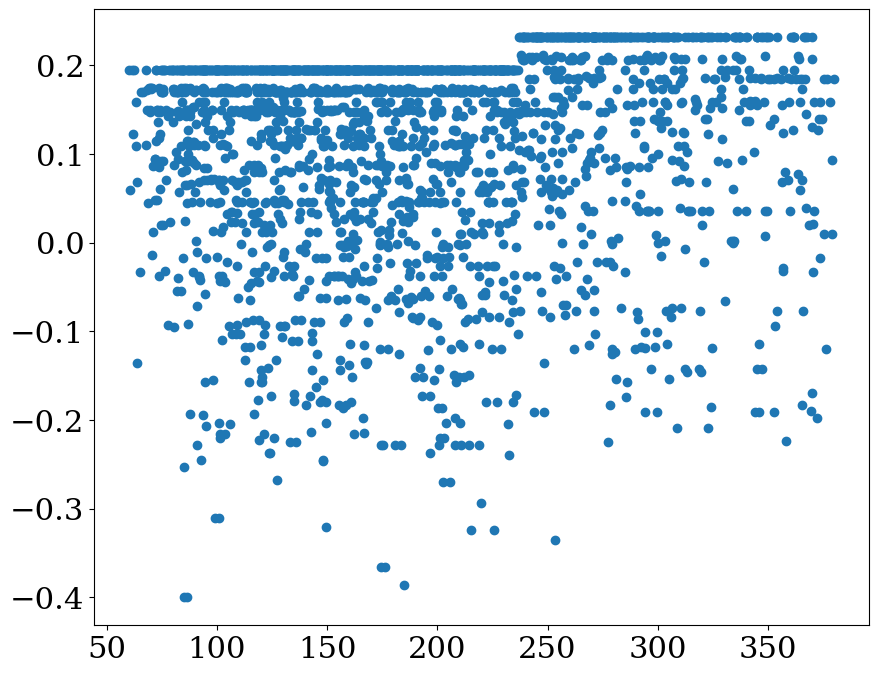

In [393]:
plt.scatter(E_test[T_test == 'tritium'], Y_score[T_test == 'tritium'])

C:\Users\lizzi\AppData\Local\Temp\ipykernel_25952\662204963.py:10: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)


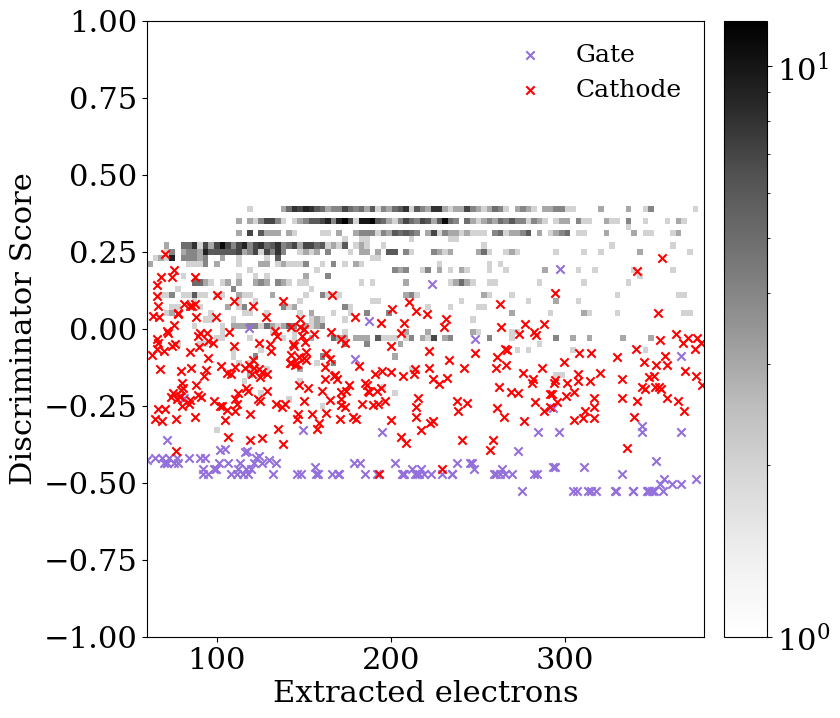

In [365]:
#heatmap 
fig, ax = plt.subplots(figsize = (8,8))
disc_score_axis = hist.axis.Regular(100,-1,1,name="disc_score",
                           label="Discriminator Score",flow=False)
disc_score_hist_trit = hist.Hist(electron_axis2, disc_score_axis)
disc_score_hist_trit.fill(E_test[T_test == 'tritium'], Y_score[T_test == 'tritium'])
disc_score_hist_trit.plot(norm=mpl.colors.LogNorm(),cmap='Greys', label = 'Tritium')
ax.scatter(E_test[T_test == 'gate'][::4], Y_score[T_test == 'gate'][::4], color = 'mediumpurple', marker = 'x', label = 'Gate')
ax.scatter(E_test[T_test == 'cathode'], Y_score[T_test == 'cathode'], color = 'red', marker = 'x', label = 'Cathode')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)


In [97]:
disc_score_cut = (-0.05 < Y_score) & (Y_score < 0.05)
gate_cut2 = T_test == 'gate'
for ii in range(1,11):
    print('%s\t%s'%(runID_test[disc_score_cut&gate_cut2].to_numpy()[ii], eventID_test[disc_score_cut&gate_cut2].to_numpy()[ii]))


6944	14366
7003	29023
6997	96097
6964	99928
6996	95393
6977	72967
6981	6568
6963	23503
7033	98138
6966	97002


In [420]:
importances = pd.DataFrame(model.feature_importances_.reshape(8,1), features)
importances

,0
max_pulse_height,0.194349
dt10_05,0.130453
dt25_10,0.101674
dt50_25,0.341220
dt75_50,0.042090
dt90_75,0.086617
dt95_90,0.085071
ext_elec,0.018525


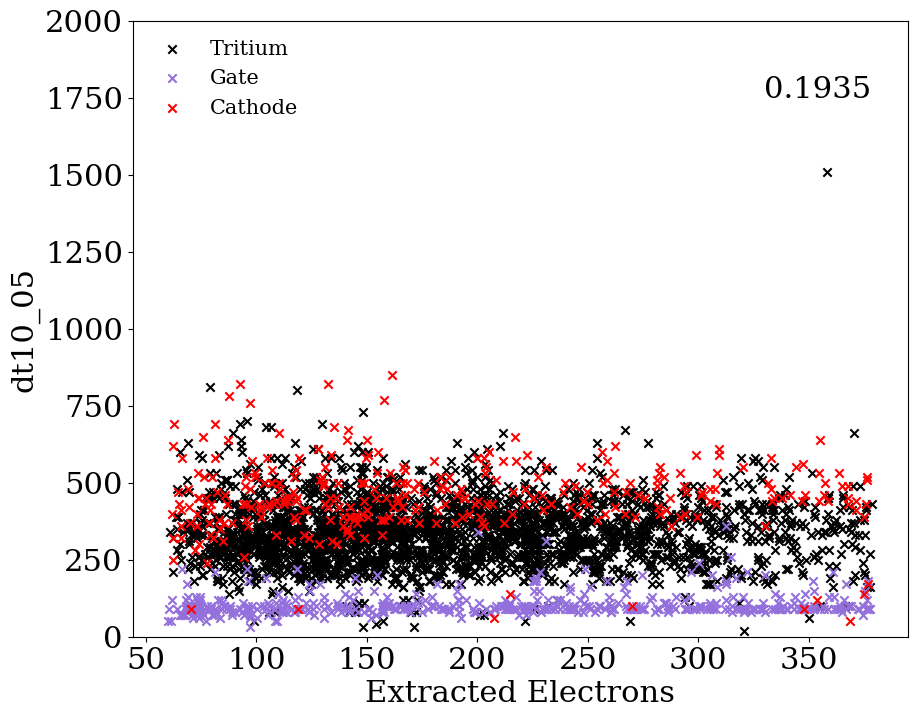

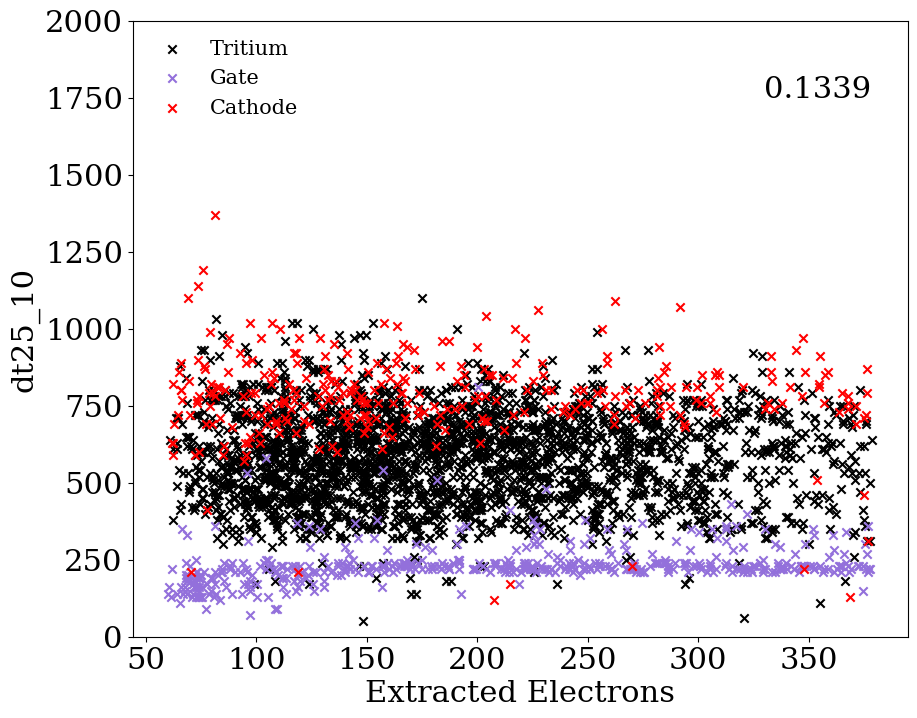

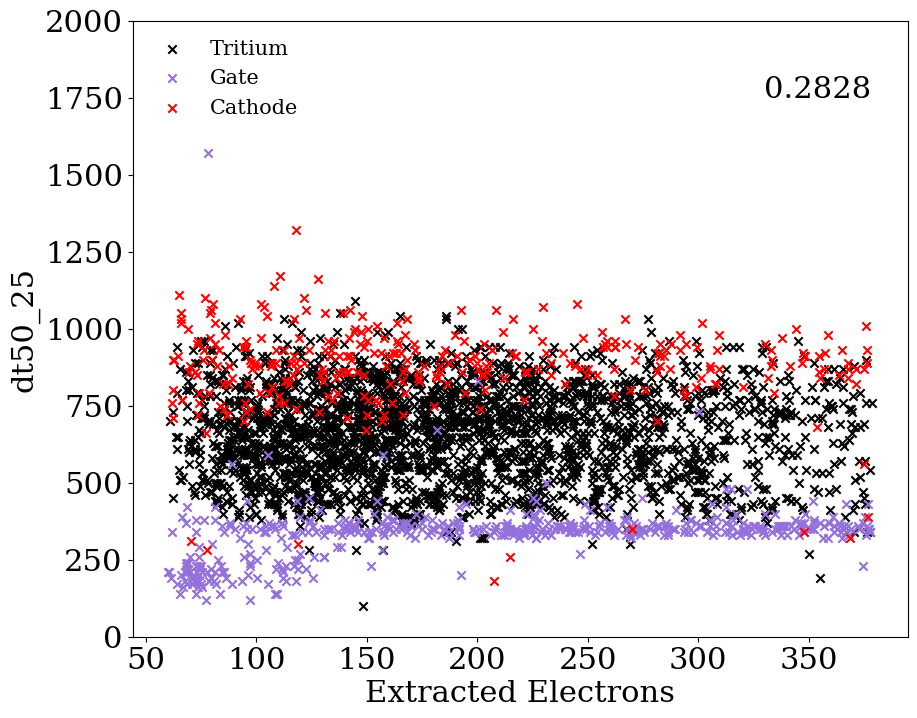

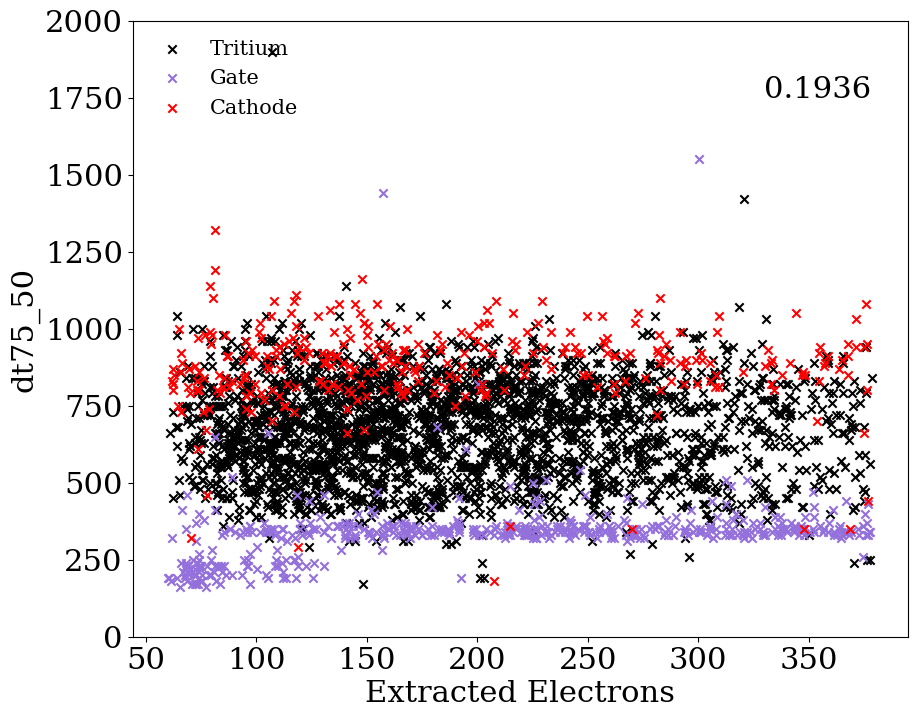

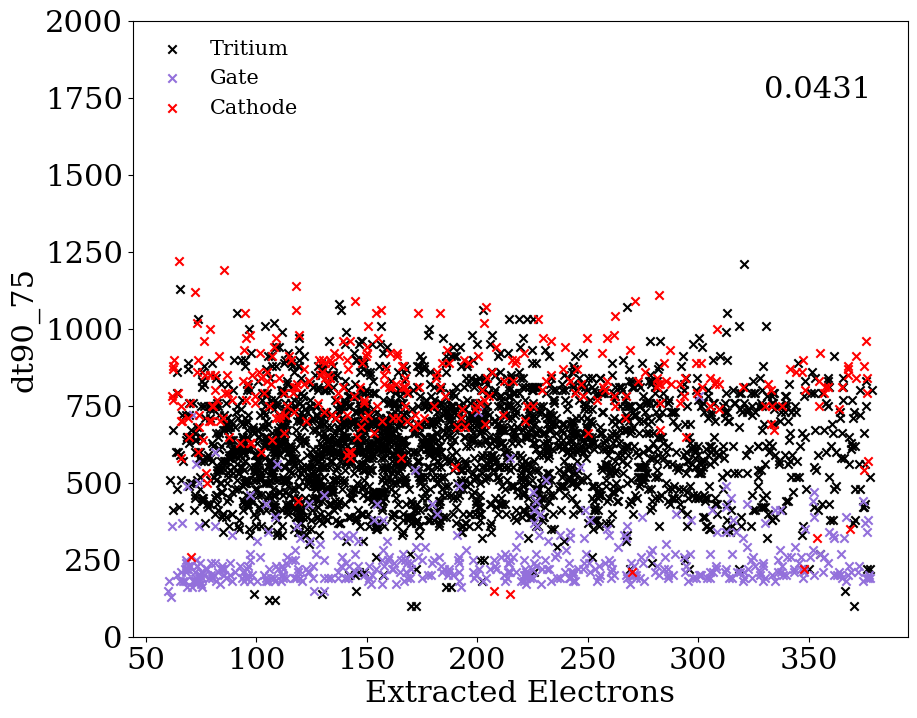

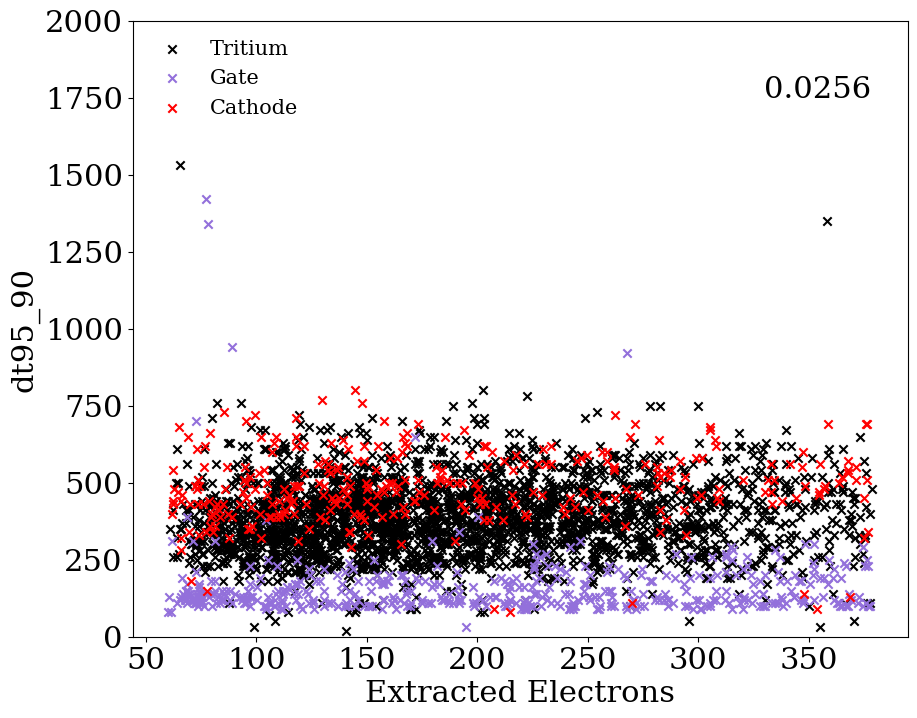

In [395]:
# making parameter plots 
time_labels = ['dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90']
maxes = [2000, 4000, 6000, 6000, 5000,3000]
for i in range(6):
    #time_axis = hist.axis.Regular(100,0,2000,name="time", label=time_labels[i],flow=False)
    #time_hist = Hist(electron_axis2, time_axis)
    #time_hist.fill(df_cut_gas.ext_elec[trit_cut2], df_cut_gas[time_labels[i]][trit_cut2])
    #time_hist.plot(norm=mpl.colors.LogNorm(),cmap='Greys', label = time_labels[i])
    plt.scatter(df_cut_gas.ext_elec[trit_cut2][::4], df_cut_gas[time_labels[i]][trit_cut2][::4], marker = 'x', color = 'black', label = 'Tritium')
    plt.scatter(df_cut_gas.ext_elec[gate_cut2][::4], df_cut_gas[time_labels[i]][gate_cut2][::4], marker = 'x', color = 'mediumpurple', label = 'Gate')
    plt.scatter(df_cut_gas.ext_elec[cath_cut2][::4], df_cut_gas[time_labels[i]][cath_cut2][::4], marker = 'x', color = 'red', label = 'Cathode')
    plt.text(330, 1750, np.round(importances[0][i+1], 4))
    plt.legend(bbox_to_anchor=(0,1),loc='upper left',frameon=False, fontsize = 15)
    plt.ylabel(time_labels[i])
    plt.xlabel('Extracted Electrons')
    plt.ylim([0,2000])
    plt.savefig(time_labels[i])
    plt.show()

In [326]:
dt50_25_cut1 = (150 < df_cut_gas.dt50_25) & (df_cut_gas.dt50_25 < 250) 
dt50_25_cut2 = (350 < df_cut_gas.dt50_25) & (df_cut_gas.dt50_25 < 400) 
blob1_cut = df_cut_gas.ext_elec < 80

for ii in range(1,11):
    print('%s\t%s'%(df_cut_gas.runID[dt50_25_cut2&gate_cut2].to_numpy()[ii], df_cut_gas.eventID[dt50_25_cut2&gate_cut2].to_numpy()[ii]))


6946	57677
6978	119997
7023	132465
7052	57869
6940	15136
6966	27644
6941	46772
7047	38782
7061	93702
6963	20202


In [208]:
# ML for only pulse width 

features2 = ['S2_width', 'ext_elec']

X2 = df_cut[features2]
Y2 = df_cut['label']
T2 = df_cut['type']
W2 = df_cut['weights_no_gas'] # - should this be the weight calculated above? 
A2 = df_cut['area']
R2 = df_cut['r']
X2_raw = df_cut['x']
Y2_raw = df_cut['y']
X2_train_unscaled, X2_test_unscaled, \
Y2_train, Y2_test, \
A2_train, A2_test, \
T2_train, T2_test, \
W2_train, W2_test, \
R2_train, R2_test, \
X2_raw_train, X2_raw_test, \
Y2_raw_train, Y2_raw_test = \
train_test_split(X2, Y2, A2, T2, W2, R2, X2_raw, Y2_raw, random_state=0)

In [209]:
scaler = MinMaxScaler()
X2_train = scaler.fit_transform(X2_train_unscaled.astype('float64'))
X2_test = scaler.transform(X2_test_unscaled.astype('float64'))
E2_test = A2_test/SE_size

In [210]:
DTC2 = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC2 = AdaBoostClassifier(base_estimator=DTC2,n_estimators=100,algorithm = 'SAMME')
model2 = ABC2.fit(X2_train, Y2_train.values.ravel()
                ,sample_weight=W2_train.values.ravel().astype('float64'))

Y2_score = model2.decision_function(X2_test)

model2.score(X2_train, Y2_train, sample_weight=W2_train.astype('float64')), \
model2.score(X2_test, Y2_test, sample_weight=W2_test.astype('float64')) 

C:\Users\lizzi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.7928710742089133, 0.7695774193152575)

In [211]:
ROC_params_list2 = []
start = 60
Y2_score = model2.decision_function(X2_test)

for i in range(8): 
    bin_cut = (start < E2_test) & (E2_test < start + 40)
    start += 40
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut],Y2_score[bin_cut],sample_weight = W2_test[bin_cut], pos_label = 1)
    ROC_params_list2.append([FPR, TPR, TH])

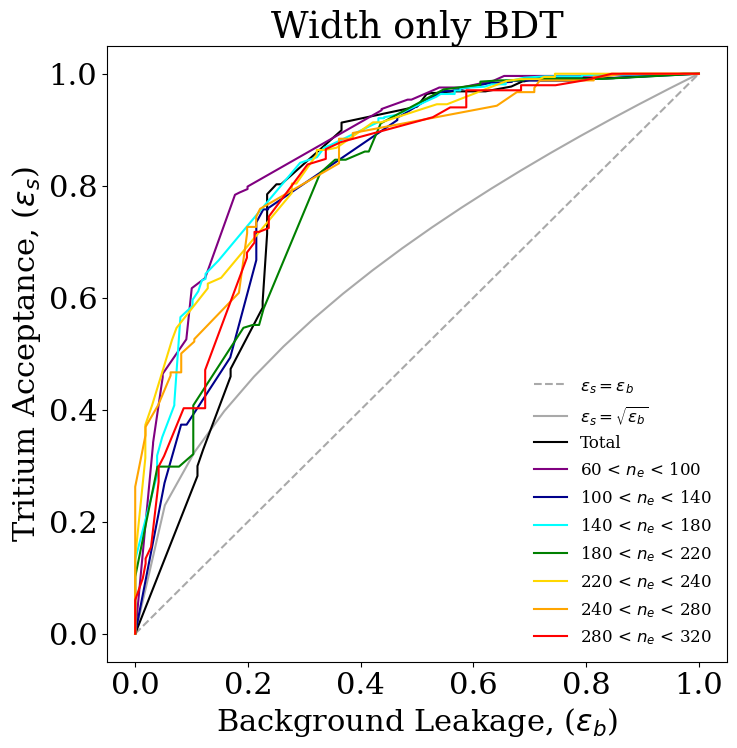

In [212]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_list2[i][0], ROC_params_list2[i][1], label = bin_labels[i], color = bin_colors[i])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Background Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_title('Width only BDT')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)


In [213]:
# splitting into gate and cathode
ROC_params_gate2 = []
ROC_params_cath2 = []
start = 60
for i in range(8): 
    bin_cut = (start < E2_test) & (E2_test < start + 40)
    start += 40
    gate_cut_ =  T2_test != 'cathode' 
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut&gate_cut_],Y2_score[bin_cut&gate_cut_],sample_weight = W2_test[bin_cut&gate_cut_], pos_label = 1)
    ROC_params_gate2.append([FPR, TPR, TH])
    cath_cut_ =  T_test != 'gate' 
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut&cath_cut_],Y2_score[bin_cut&cath_cut_],sample_weight = W2_test[bin_cut&cath_cut_], pos_label = 1)
    ROC_params_cath2.append([FPR, TPR, TH])


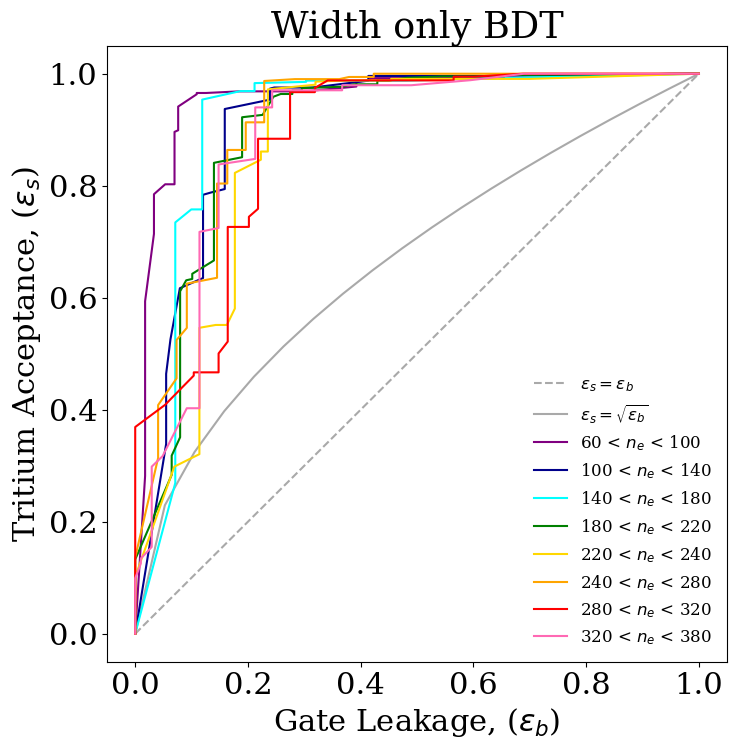

In [214]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_gate2[i][0], ROC_params_gate2[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_title('Width only BDT')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

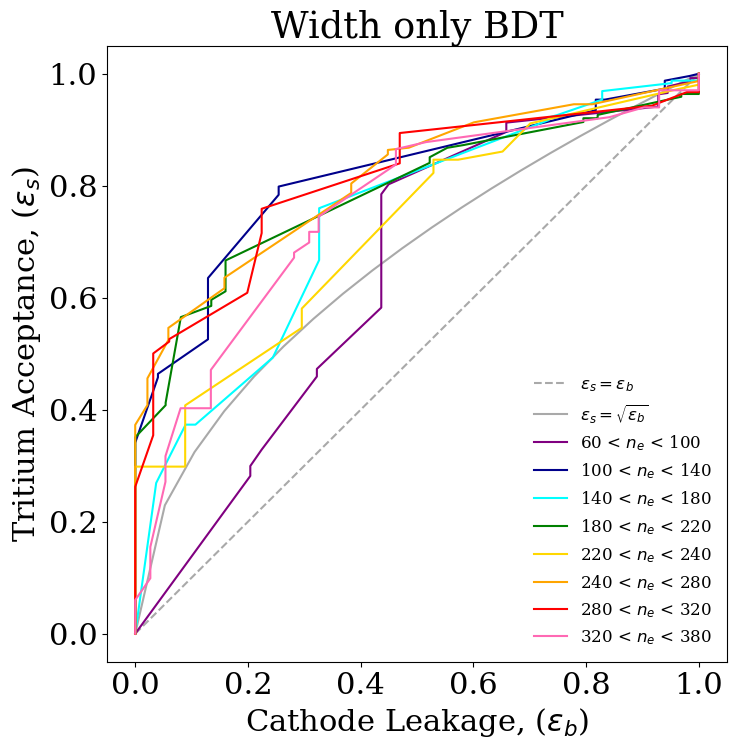

In [215]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_cath2[i][0], ROC_params_cath2[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Cathode Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.set_title('Width only BDT')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

In [216]:
model2.feature_importances_

array([0.75265831, 0.24734169])

#TODO

- Histogram with gas events 
- BDT without gas events 
    - Same ROC curves for this BDT as before
- Histograms of params against S2 size
    - Split into classes
- 1D histograms of params 
- 1D histogram of y score for each bin, sep into gate, cath, trit
    - plot line to keep 80% of trit events (disc_score_cut)
    - apply cut & normalise with total events to get data point
    - width from width of bin
    - yerror from poisson error - sqrt(num)/demon
- Make for width only BDT also
- Optimise hyperparams 
- Clean up notebook & make final plots 


# Notes 
- Importances didn't make sense visually from dtxx_xx scatter plots so ran BDTs with only gate and only cathode
    - Cathode heavily favouring the dt50_25 which explains the skew 
- Ran with max_depth set to 1 which fixed the test error? Also made the importances a bit more even 